In [2]:
import pandas as pd
from openpyxl import load_workbook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import warnings
warnings.filterwarnings('ignore')
#pd.reset_option('display.max_columns')

from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFECV, RFE, SelectFromModel, SelectKBest, chi2
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, Normalizer, QuantileTransformer, PowerTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesRegressor, RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, RandomForestRegressor
from sklearn import feature_selection
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

from lightgbm import LGBMClassifier

#import shap

### Data ensembling

In [18]:
descriptor_df = pd.read_excel('dummy.xlsx', None)
all_ligand_descriptors = []
for key in descriptor_df.keys():
    all_ligand_descriptors.append(descriptor_df[key])
descriptors_concatenated = pd.concat(all_ligand_descriptors,axis=0,ignore_index=True)

In [19]:
dummy_df = descriptors_concatenated
dummy_df.drop('Unnamed: 0', axis=1, inplace=True)

In [20]:
dummy_df.index

RangeIndex(start=0, stop=128, step=1)

In [21]:
all_ligands = dummy_df.loc[0:63,:]
dummy_df =  dummy_df.loc[0:63,:]

In [11]:
#all_ligands_ic50 = pd.DataFrame(all_ligands, columns=['Ligand'])
#all_ligands_ic50.to_excel("/home/alexis/Desktop/PeleAI_data/y_data_all_lignads.xlsx")

In [5]:
dummy_df = dummy_df.loc[0:63,:]

In [13]:
lig = pd.DataFrame(dummy_df, columns=['Ligand'])
lig.to_excel("/home/vant/data/PeleAI_data/ligands_list.xlsx")
lig

,Ligand
0,39_SD-027
1,24_SD-012
2,102_wo17590_77
3,1_BMS986165_PKD_TYK2_prw_nowater_nimbus01
4,60_wo14660_81
5,30_SD-018
6,71_wo14670_11
7,95_wo15310_41
8,8_BMS986165_PKD_TYK2_prw_nowaternimbus08
9,75_wo14670_1


#### Non-applying descriptors search

Search for those descriptors that could not be computed by _Modrded_ and discard them.

In [7]:
non_applying_descriptors = []
num_descriptors = len(al.columns)

for i in range(1, num_descriptors):
    if (str(dummy_df.dtypes[i]) != 'float64') and (str(dummy_df.dtypes[i]) != 'int64') and (str(dummy_df.dtypes[i]) != 'bool'):
        non_applying_descriptors.append(dummy_df.columns[i])
        

In [8]:
for descriptor in non_applying_descriptors:
    dummy_df.drop(columns=[descriptor], inplace=True)

#### _BMS_ and _wo_ ligands dropping

We decided to discard this two groups of ligads as they come from two alternative sources. 
We keep on working with _SD_ and _LAS_.

In [9]:
for index, row in dummy_df.iterrows():
    if 'BMS' in row['Ligand']:
        dummy_df.drop(index, inplace=True)

for index, row in dummy_df.iterrows():
    if 'wo' in row['Ligand']:
        dummy_df.drop(index, inplace=True)
        
for index, row in dummy_df.iterrows():
    if '30_' in row['Ligand']:
        dummy_df.drop(index, inplace=True)

In [10]:
dummy_df.reset_index(drop=True, inplace=True)
dummy_df['Ligand']

0        39_SD-027
1        24_SD-012
2        29_SD-017
3        33_SD-021
4        17_SD-002
5        36_SD-024
6        18_SD-003
7        25_SD-013
8        23_SD-011
9     12_LAS203756
10       34_SD-022
11       28_SD-016
12       26_SD-014
13       37_SD-025
14    13_LAS203888
15       21_SD-009
16       19_SD-006
17       22_SD-010
18       35_SD-023
19       38_SD-026
20       32_SD-020
21    15_LAS203932
22       31_SD-019
23    16_LAS203965
24    14_LAS203900
25       27_SD-015
26       20_SD-008
Name: Ligand, dtype: object

In [23]:
dummy_df.sort_values(by=['Ligand'], inplace=True)
dummy_df.reset_index(drop=True, inplace=True)
dummy_df.head(64)

,Ligand,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,100_wo17590_27,21.120393,17.395811,0,0,35.044844,2.490618,4.890757,35.044844,1.297957,...,10.293196,76.495281,367.175673,7.649493,1874,42,144,172,7.750000,6.055556
1,101_wo17590_2,20.672506,16.728469,0,0,33.426006,2.491886,4.885283,33.426006,1.285616,...,10.242777,80.655048,354.160437,7.870232,1687,40,142,169,8.111111,5.611111
2,102_wo17590_77,20.413286,16.725919,0,0,34.468616,2.492661,4.888530,34.468616,1.325716,...,10.230955,80.593694,352.164774,7.655756,1672,41,140,168,7.500000,5.805556
3,103_wo17590_84,22.494166,17.412162,0,0,37.746202,2.495751,4.915320,37.746202,1.348079,...,10.391607,83.229942,380.159689,7.919994,2035,46,156,189,7.111111,6.083333
4,104_wo17590_85,23.241713,18.356884,0,0,38.878496,2.492046,4.885544,38.878496,1.340638,...,10.338414,84.830777,389.171256,8.107735,2337,44,160,192,7.361111,6.305556
5,105_wo17590_88,24.017769,19.082824,0,0,39.894904,2.492434,4.887571,39.894904,1.329830,...,10.396933,86.148121,406.186572,7.811280,2561,47,166,200,8.222222,6.500000
6,106_wo17590_89,26.485286,20.586688,0,0,42.676460,2.492619,4.886618,42.676460,1.293226,...,10.522046,89.726821,457.158641,8.963895,3425,52,184,220,10.284722,6.972222
7,107_wo17590_91,24.017769,19.082824,0,0,39.894904,2.492434,4.887571,39.894904,1.329830,...,10.396933,86.148121,405.166171,8.268697,2561,47,166,200,8.222222,6.500000
8,10_BMS986165_PKD_TYK2_prw_nowater_nimbus10,27.024536,20.894750,0,2,44.354454,2.506928,4.935683,44.354454,1.304543,...,10.525595,86.611577,461.203619,8.091292,3447,56,186,223,10.444444,7.361111
9,12_LAS203756,24.793826,18.444754,0,0,41.003700,2.499482,4.946810,41.003700,1.322700,...,10.454812,81.186093,423.150681,8.463014,2776,52,170,204,8.472222,6.694444


#### pIC50 values loading

In [7]:
pic50_raw = pd.read_excel('/home/alexis/Desktop/PeleAI_data/y_data.xlsx')

In [8]:
pic50_raw['Ligand']

0     12_LAS203756
1     13_LAS203888
2     14_LAS203900
3     15_LAS203932
4     16_LAS203965
5        17_SD-002
6        18_SD-003
7        19_SD-006
8        20_SD-008
9        21_SD-009
10       22_SD-010
11       23_SD-011
12       24_SD-012
13       25_SD-013
14       26_SD-014
15       27_SD-015
16       28_SD-016
17       29_SD-017
18       31_SD-019
19       32_SD-020
20       33_SD-021
21       34_SD-022
22       35_SD-023
23       36_SD-024
24       37_SD-025
25       38_SD-026
26       39_SD-027
Name: Ligand, dtype: object

### Descriptor curation

#### Correlation matrix and high correlated descriptors dropping

Computing of the correlation matrix, plotted below, of the ~1500 descriptors computed. Those descriptors that show a correlation coefficient above 0.8 will be discarded.

In [14]:
correlated_features = set()
correlation_matrix = dummy_df.drop('Ligand', axis=1).corr()

In [15]:
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i,j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
            
print(correlated_features)

{'ETA_dAlpha_B', 'ATS5i', 'BCUTd-1h', 'ATSC1are', 'BCUTse-1h', 'AATSC7dv', 'VE1_D', 'ETA_beta', 'BCUTare-1l', 'AATSC3are', 'WPSA1', 'CIC2', 'ATSC3pe', 'VR3_Dzpe', 'ATSC8se', 'AATSC1s', 'MATS8c', 'AATS3p', 'ATS1dv', 'n6HRing', 'TopoPSA', 'ATS0m', 'ETA_beta_ns', 'AATSC3dv', 'AATSC5m', 'GRAV', 'ATS4v', 'ATSC2are', 'FPSA5', 'Xpc-4d', 'piPC8', 'Xc-4d', 'MATS6m', 'ATSC8c', 'EState_VSA1', 'AATS2are', 'AATS8pe', 'Xch-6dv', 'VR3_DzZ', 'Xch-3d', 'GATS8se', 'AATSC1se', 'SpMax_D', 'SaaNH', 'ATS1pe', 'SZ', 'MATS3p', 'AATS6Z', 'AATSC3se', 'IC2', 'MOMI-Z', 'AATSC2i', 'MATS6dv', 'nBondsD', 'EState_VSA2', 'BIC1', 'AATSC8se', 'MATS7pe', 'MATS2i', 'AATS7s', 'BCUTi-1l', 'ATSC1Z', 'SM1_Dzv', 'AATS2se', 'ATSC5p', 'SIC5', 'n4ARing', 'VE2_D', 'SpDiam_Dzse', 'GATS3are', 'AETA_alpha', 'mZagreb1', 'MATS7are', 'VMcGowan', 'AATSC3v', 'GATS4se', 'ATSC0se', 'MID_X', 'PPSA3', 'ATSC6v', 'AATSC0d', 'ATS2v', 'ETA_eta_L', 'MATS4v', 'GATS6v', 'SlogP_VSA7', 'GATS4pe', 'ATS0p', 'AATSC5s', 'GATS8Z', 'MATS5m', 'AATSC4i', 'Ber

In [16]:
print("Correlated descriptors computed: {}".format(len(correlated_features)))
print("Number of descriptors before discard: {}".format(len(dummy_df.columns)))
dummy_df = dummy_df.drop(correlated_features, axis=1)
print("Number of descriptors after discard: {}".format(len(dummy_df.columns)))

Correlated descriptors computed: 1102
Number of descriptors before discard: 1503
Number of descriptors after discard: 401


#### Correlation matrix

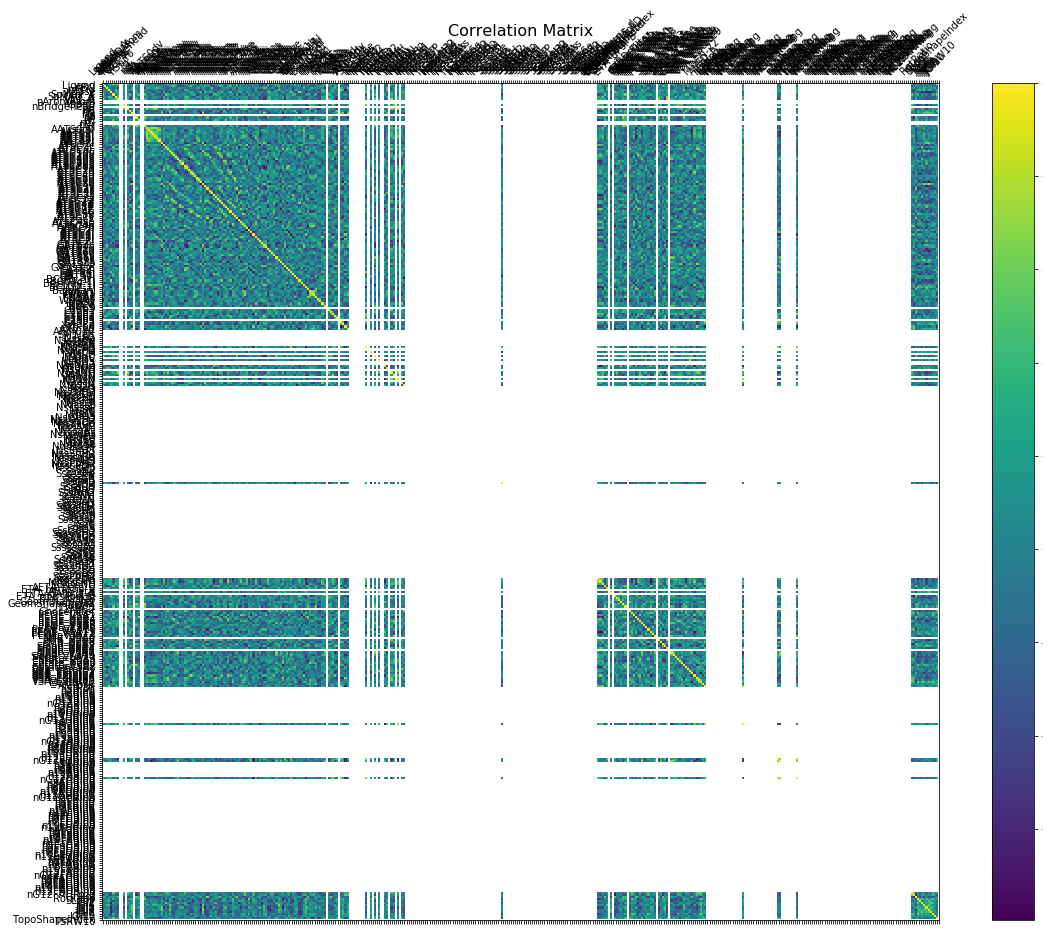

In [17]:
f = plt.figure(figsize=(19, 15))
plt.matshow(dummy_df.corr(), fignum=f.number)
plt.xticks(range(dummy_df.shape[1]), dummy_df.columns, fontsize=10, rotation=45)
plt.yticks(range(dummy_df.shape[1]), dummy_df.columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=1)
plt.title('Correlation Matrix', fontsize=16);

### Data splitting

In [18]:
dummy_df = dummy_df.merge(pic50_raw, how='left')

In [19]:
dummy_df.head()

,Ligand,ABC,nAcid,nBase,SpMax_A,SpMAD_A,VE1_A,VR1_A,nAromAtom,nSpiro,...,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10,TopoShapeIndex,TSRW10,IC50
0,12_LAS203756,24.793826,0,0,2.499482,1.322700,4.440538,597.574331,18,0,...,0.026757,0.028958,0.017766,0.015289,0.008381,0.006972,0.006926,0.875,81.186093,-4.824
1,13_LAS203888,17.953468,0,0,2.481106,1.246964,3.925606,230.400001,15,0,...,0.040794,0.033704,0.018925,0.013818,0.014253,0.012246,0.004115,1.000,71.498752,-10.292
2,14_LAS203900,24.017769,0,1,2.489954,1.330078,4.496545,499.352788,21,0,...,0.028804,0.016311,0.018386,0.012110,0.005810,0.006563,0.004835,0.875,79.976698,-7.284
3,15_LAS203932,23.529442,0,0,2.438811,1.287772,4.888546,227.217438,17,0,...,0.034610,0.025721,0.017908,0.013517,0.010860,0.008173,0.008159,1.000,85.157707,-11.456
4,16_LAS203965,21.896449,0,0,2.550926,1.310703,4.089075,1640.002566,18,0,...,0.040631,0.025306,0.017225,0.012408,0.009386,0.009661,0.006200,0.875,79.570682,-7.259


In [75]:
train, test = train_test_split(dummy_df, test_size=0.24)

In [76]:
test

,Ligand,ABC,nAcid,nBase,SpMax_A,SpMAD_A,VE1_A,VR1_A,nAromAtom,nSpiro,...,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10,TopoShapeIndex,TSRW10,IC50
18,31_SD-019,23.128092,0,0,2.485026,1.265543,4.589305,245.959491,12,0,...,0.036926,0.024543,0.020116,0.014527,0.015052,0.009667,0.009047,1.000000,84.463671,-7.886
5,17_SD-002,20.810405,0,0,2.411799,1.257524,4.763671,169.907127,12,0,...,0.032724,0.030293,0.017606,0.016470,0.009910,0.009087,0.008048,1.000000,80.526405,-8.337
25,38_SD-026,20.579394,0,2,2.567485,1.276277,4.206620,241.043676,10,0,...,0.048462,0.034330,0.019147,0.014064,0.011379,0.011941,0.010209,1.000000,77.712224,-5.174
22,35_SD-023,22.931725,0,0,2.433999,1.275335,4.873163,204.691400,17,0,...,0.029697,0.029065,0.015626,0.016370,0.008494,0.010563,0.006171,1.000000,84.032246,-6.886
2,14_LAS203900,24.017769,0,1,2.489954,1.330078,4.496545,499.352788,21,0,...,0.028804,0.016311,0.018386,0.012110,0.005810,0.006563,0.004835,0.875000,79.976698,-7.284
0,12_LAS203756,24.793826,0,0,2.499482,1.322700,4.440538,597.574331,18,0,...,0.026757,0.028958,0.017766,0.015289,0.008381,0.006972,0.006926,0.875000,81.186093,-4.824
11,23_SD-011,21.679272,0,0,2.366948,1.253763,4.624579,283.956052,17,0,...,0.021742,0.029689,0.016776,0.014010,0.008412,0.009403,0.008081,0.888889,76.413702,-7.854


In [77]:
train

,Ligand,ABC,nAcid,nBase,SpMax_A,SpMAD_A,VE1_A,VR1_A,nAromAtom,nSpiro,...,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10,TopoShapeIndex,TSRW10,IC50
26,39_SD-027,16.401355,0,0,2.351515,1.311378,3.989248,179.986399,12,0,...,0.040362,0.023865,0.009515,0.014640,0.009574,0.007217,0.007414,0.857143,72.950827,-4.824
9,21_SD-009,21.408122,0,0,2.415928,1.272444,4.819938,183.316566,12,0,...,0.035038,0.028826,0.017143,0.015625,0.010097,0.009063,0.008072,1.000000,81.665307,-9.268
7,19_SD-006,20.046279,0,0,2.366458,1.287238,4.561329,210.869853,17,0,...,0.024377,0.028020,0.018295,0.011736,0.009113,0.008393,0.009068,1.000000,74.088365,-8.194
20,33_SD-021,25.622253,0,0,2.474584,1.306494,4.328259,561.790476,18,0,...,0.026194,0.027943,0.014496,0.013086,0.009859,0.009540,0.005906,1.000000,82.166191,-6.469
24,37_SD-025,22.753386,1,0,2.475054,1.300798,4.367584,549.602686,15,0,...,0.038463,0.026222,0.019152,0.014123,0.012124,0.009138,0.007070,0.875000,78.590066,-6.854
10,22_SD-010,24.288920,0,1,2.367520,1.301283,4.747259,419.620993,17,0,...,0.023889,0.025965,0.015395,0.010213,0.007749,0.007639,0.006485,0.900000,80.035639,-8.721
23,36_SD-024,17.236029,0,3,2.465598,1.236262,4.134028,180.284855,5,0,...,0.032796,0.031099,0.023850,0.017306,0.014143,0.010605,0.007522,1.000000,70.296651,-5.509
15,27_SD-015,27.512863,0,0,2.492887,1.336666,4.823638,530.661007,21,0,...,0.034931,0.021442,0.017890,0.010635,0.008011,0.007116,0.005979,1.000000,85.660541,-6.509
6,18_SD-003,20.632065,0,0,2.403846,1.291365,4.680105,186.452688,12,0,...,0.033764,0.028882,0.016961,0.013696,0.009962,0.008996,0.007448,1.000000,80.381982,-9.284
14,26_SD-014,25.012606,0,0,2.442549,1.278882,4.985878,258.000375,11,0,...,0.031133,0.029494,0.016569,0.014376,0.009877,0.009427,0.008426,0.857143,87.477037,-7.066


In [78]:
ic50_train = train['IC50']
ic50_test = test['IC50']

In [79]:
ic50_train

26    -4.824
9     -9.268
7     -8.194
20    -6.469
24    -6.854
10    -8.721
23    -5.509
15    -6.509
6     -9.284
14    -7.066
1    -10.292
19    -5.699
3    -11.456
16    -5.312
17    -7.886
4     -7.259
12    -5.796
21    -6.658
8     -9.420
13    -6.456
Name: IC50, dtype: float64

In [80]:
ic50_test

18   -7.886
5    -8.337
25   -5.174
22   -6.886
2    -7.284
0    -4.824
11   -7.854
Name: IC50, dtype: float64

In [81]:
train.drop(['Ligand','IC50'], axis=1, inplace=True)
test.drop(['Ligand','IC50'], axis=1, inplace=True)

In [82]:
train.head()

,ABC,nAcid,nBase,SpMax_A,SpMAD_A,VE1_A,VR1_A,nAromAtom,nSpiro,nBridgehead,...,JGI2,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10,TopoShapeIndex,TSRW10
26,16.401355,0,0,2.351515,1.311378,3.989248,179.986399,12,0,0,...,0.065476,0.040362,0.023865,0.009515,0.014640,0.009574,0.007217,0.007414,0.857143,72.950827
9,21.408122,0,0,2.415928,1.272444,4.819938,183.316566,12,0,0,...,0.086895,0.035038,0.028826,0.017143,0.015625,0.010097,0.009063,0.008072,1.000000,81.665307
7,20.046279,0,0,2.366458,1.287238,4.561329,210.869853,17,0,0,...,0.064327,0.024377,0.028020,0.018295,0.011736,0.009113,0.008393,0.009068,1.000000,74.088365
20,25.622253,0,0,2.474584,1.306494,4.328259,561.790476,18,0,0,...,0.052288,0.026194,0.027943,0.014496,0.013086,0.009859,0.009540,0.005906,1.000000,82.166191
24,22.753386,1,0,2.475054,1.300798,4.367584,549.602686,15,0,0,...,0.074074,0.038463,0.026222,0.019152,0.014123,0.012124,0.009138,0.007070,0.875000,78.590066


In [83]:
test.head()

,ABC,nAcid,nBase,SpMax_A,SpMAD_A,VE1_A,VR1_A,nAromAtom,nSpiro,nBridgehead,...,JGI2,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10,TopoShapeIndex,TSRW10
18,23.128092,0,0,2.485026,1.265543,4.589305,245.959491,12,0,0,...,0.080247,0.036926,0.024543,0.020116,0.014527,0.015052,0.009667,0.009047,1.000,84.463671
5,20.810405,0,0,2.411799,1.257524,4.763671,169.907127,12,0,0,...,0.089181,0.032724,0.030293,0.017606,0.016470,0.009910,0.009087,0.008048,1.000,80.526405
25,20.579394,0,2,2.567485,1.276277,4.206620,241.043676,10,0,0,...,0.103175,0.048462,0.034330,0.019147,0.014064,0.011379,0.011941,0.010209,1.000,77.712224
22,22.931725,0,0,2.433999,1.275335,4.873163,204.691400,17,0,0,...,0.078811,0.029697,0.029065,0.015626,0.016370,0.008494,0.010563,0.006171,1.000,84.032246
2,24.017769,0,1,2.489954,1.330078,4.496545,499.352788,21,0,0,...,0.064815,0.028804,0.016311,0.018386,0.012110,0.005810,0.006563,0.004835,0.875,79.976698


#### Replace Na values

Also to replace with mean or median

In [84]:
train.fillna(value=0.0, inplace=True)
test.fillna(value=0.0, inplace=True)

#### Transform pIC50 values

In [85]:
ic50_train_enc = [1 if ic50 > -7 else 0 for ic50 in ic50_train.values]
ic50_test_enc = [1 if ic50 > -7 else 0 for ic50 in ic50_test.values]

In [86]:
train.to_csv("train.csv")
ic50_train.to_csv("ic50_train.csv")
df_ic50_train_enc = pd.DataFrame(ic50_train_enc)
df_ic50_train_enc.to_csv("ic50_train_enc.csv")
test.to_csv("test.csv")
ic50_test.to_csv("ic50_test.csv")
df_ic50_test_enc = pd.DataFrame(ic50_test_enc)
df_ic50_test_enc.to_csv("ic50_test_enc.csv")

#### Scaling

##### Standard

In [87]:
scaler = StandardScaler()

In [88]:
train_sc = scaler.fit_transform(train)
test_sc = scaler.fit_transform(test)

##### MinMax

In [89]:
scaler = MinMaxScaler()

In [90]:
train_mmsc = scaler.fit_transform(train)
test_mmsc = scaler.fit_transform(test)

##### MaxAbs

In [91]:
scaler = MaxAbsScaler()

In [92]:
train_masc = scaler.fit_transform(train)
test_masc = scaler.fit_transform(test)

##### Robust 

In [93]:
scaler = RobustScaler()

In [94]:
train_rsc = scaler.fit_transform(train)
test_rsc = scaler.fit_transform(test)

##### Power Transformer - Yeo-Johnson

In [95]:
scaler = PowerTransformer(method='yeo-johnson')

In [96]:
train_yjsc = scaler.fit_transform(train)
test_yjsc = scaler.fit_transform(test)

##### Quantile transformer - Gaussian

In [97]:
scaler = QuantileTransformer(output_distribution='normal')

In [98]:
train_gsc = scaler.fit_transform(train)
test_gsc = scaler.fit_transform(test)

##### Quantile transformer - Uniform

In [99]:
scaler = QuantileTransformer(output_distribution='uniform')

In [100]:
train_usc = scaler.fit_transform(train)
test_usc = scaler.fit_transform(test)

##### Normalizer

In [101]:
scaler = Normalizer()

In [102]:
train_nsc = scaler.fit_transform(train)
test_nsc = scaler.fit_transform(test)

## Feature selection

#### Shap values

In [ ]:
model = RandomForestClassifier(random_state=101)
model.fit(train, ic50_train_enc)

In [ ]:
shap_values = shap.TreeExplainer(model).shap_values(train)
shap.summary_plot(shap_values, train, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, train)

In [ ]:
shap.initjs()

In [ ]:
X_output = test.copy()
X_output.loc[:,'predict'] = np.round(model.predict(X_output),2)

# Randomly pick some observations
random_picks = np.arange(1,7,2) # Every 50 rows
S = X_output.iloc[random_picks]
S

In [ ]:
def shap_plot(j):
    explainerModel = shap.TreeExplainer(model)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
    return(p)

In [ ]:
shap_plot(0)

In [ ]:
shap_plot(1)

In [ ]:
shap_plot(2)

#### Pearson correlation

In [103]:
def cor_selector(X, y, num_feats):
    cor_list = []
    feature_name = X.columns.tolist()

    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)

    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    cor_support = [True if i in cor_feature else False for i in feature_name]
    
    return cor_support, cor_feature 

In [104]:
cor_support, cor_feature = cor_selector(train, ic50_train_enc, len(train.columns))
print(str(len(cor_feature)), 'selected features')

400 selected features


#### LASSO

In [105]:
embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=len(train.columns))
embeded_lr_selector.fit(train_mmsc, ic50_train_enc)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = train.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

136 selected features


In [58]:
train.drop(train.columns[np.where(embeded_lr_support == False)[0]], axis=1, inplace=True)
test.drop(test.columns[np.where(embeded_lr_support == False)[0]], axis=1, inplace=True)

#### Chi-squared

In [106]:
chi_selector = SelectKBest(chi2, k=400)
chi_selector.fit(train_mmsc, ic50_train_enc)

SelectKBest(k=400, score_func=<function chi2 at 0x7fa6f7c443b0>)

In [107]:
chi_support = chi_selector.get_support()
chi_feature = train.loc[:,chi_support].columns.tolist()

In [108]:
print(str(len(chi_feature)), 'selected features')

400 selected features


#### Light Gradient Boosting Classifier

In [109]:
lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

In [110]:
embeded_lgb_selector = SelectFromModel(lgbc, max_features=len(train.columns))
embeded_lgb_selector.fit(train_mmsc, ic50_train_enc)

SelectFromModel(estimator=LGBMClassifier(boosting_type='gbdt',
                                         class_weight=None,
                                         colsample_bytree=0.2,
                                         importance_type='split',
                                         learning_rate=0.05, max_depth=-1,
                                         min_child_samples=20,
                                         min_child_weight=40,
                                         min_split_gain=0.01, n_estimators=500,
                                         n_jobs=-1, num_leaves=32,
                                         objective=None, random_state=None,
                                         reg_alpha=3, reg_lambda=1, silent=True,
                                         subsample=1.0,
                                         subsample_for_bin=200000,
                                         subsample_freq=0),
                max_features=400, norm_order=1, prefit=False,

In [111]:
embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = train.loc[:,embeded_lgb_support].columns.tolist()

In [112]:
print(str(len(embeded_lgb_feature)), 'selected features')

400 selected features


### Recursive feature elimination (RFE)

#### By Support Vector Classifier (SVC)

- Error report:

        * n_splits=2 cannot be greater than the number of members in each class.
        * The classifier does not expose "coef_" or "feature_importances_" attributes
        
Dependence on train/test split

In [113]:
svc = LinearSVC()
rfe = RFE(svc)
rfe.fit(train, ic50_train_enc)
print('Optimal number of features: {} - '.format(rfe.n_features_))
rfe.fit(train_sc, ic50_train_enc)
print('Optimal number of features: {} - Standard'.format(rfe.n_features_))
rfe.fit(train_mmsc, ic50_train_enc)
print('Optimal number of features: {} - MinMax'.format(rfe.n_features_))
rfe.fit(train_masc, ic50_train_enc)
print('Optimal number of features: {} - MaxAbs'.format(rfe.n_features_))
rfe.fit(train_rsc, ic50_train_enc)
print('Optimal number of features: {} - Robust'.format(rfe.n_features_))
rfe.fit(train_yjsc, ic50_train_enc)
print('Optimal number of features: {} - Yeo-Johnson'.format(rfe.n_features_))
rfe.fit(train_gsc, ic50_train_enc)
print('Optimal number of features: {} - Gaussian'.format(rfe.n_features_))
rfe.fit(train_usc, ic50_train_enc)
print('Optimal number of features: {} - uniform'.format(rfe.n_features_))
rfe.fit(train_nsc, ic50_train_enc)
print('Optimal number of features: {} - normalized'.format(rfe.n_features_))


Optimal number of features: 200 - 
Optimal number of features: 200 - Standard
Optimal number of features: 200 - MinMax
Optimal number of features: 200 - MaxAbs
Optimal number of features: 200 - Robust
Optimal number of features: 200 - Yeo-Johnson
Optimal number of features: 200 - Gaussian
Optimal number of features: 200 - uniform
Optimal number of features: 200 - normalized


In [ ]:
#print(np.where(rfe.support_ == False)[0])

train.drop(train.columns[np.where(rfe.support_ == False)[0]], axis=1, inplace=True)
test.drop(test.columns[np.where(rfe.support_ == False)[0]], axis=1, inplace=True)

##### Standard

In [ ]:
scaler = StandardScaler()

In [ ]:
train_sc = scaler.fit_transform(train)
test_sc = scaler.fit_transform(test)

##### MinMax

In [ ]:
scaler = MinMaxScaler()

In [ ]:
train_mmsc = scaler.fit_transform(train)
test_mmsc = scaler.fit_transform(test)

##### MaxAbs

In [ ]:
scaler = MaxAbsScaler()

In [ ]:
train_masc = scaler.fit_transform(train)
test_masc = scaler.fit_transform(test)

##### Robust 

In [ ]:
scaler = RobustScaler()

In [ ]:
train_rsc = scaler.fit_transform(train)
test_rsc = scaler.fit_transform(test)

##### Power Transformer - Yeo-Johnson

In [ ]:
scaler = PowerTransformer(method='yeo-johnson')

In [ ]:
train_yjsc = scaler.fit_transform(train)
test_yjsc = scaler.fit_transform(test)

##### Quantile transformer - Gaussian

In [ ]:
scaler = QuantileTransformer(output_distribution='normal')

In [ ]:
train_gsc = scaler.fit_transform(train)
test_gsc = scaler.fit_transform(test)

##### Quantile transformer - Uniform

In [ ]:
scaler = QuantileTransformer(output_distribution='uniform')

In [ ]:
train_usc = scaler.fit_transform(train)
test_usc = scaler.fit_transform(test)

##### Normalizer

In [ ]:
scaler = Normalizer()

In [ ]:
train_nsc = scaler.fit_transform(train)
test_nsc = scaler.fit_transform(test)

#### By Ensemble, Random Forest (RF) and Extremely Randomized Trees (Extra Trees Classifier)

##### Ensemble

In [114]:
stump = DecisionTreeClassifier(max_depth=1)
ensemble = BaggingClassifier(base_estimator = stump, n_estimators = 1000, bootstrap = False)

In [115]:
stump.fit(train, np.ravel(ic50_train_enc))
ensemble.fit(train, np.ravel(ic50_train_enc))

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=1,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,
   

In [116]:
y_pred_stump = stump.predict(test)
y_pred_ensemble = ensemble.predict(test)

In [117]:
stump_accuracy = metrics.accuracy_score(ic50_test_enc, y_pred_stump)
ensemble_accuracy = metrics.accuracy_score(ic50_test_enc, y_pred_ensemble)

In [118]:
print(f"The accuracy of the stump is {stump_accuracy*100:.1f} %")
print(f"The accuracy of the ensemble is {ensemble_accuracy*100:.1f} %")

The accuracy of the stump is 57.1 %
The accuracy of the ensemble is 57.1 %


##### Random Forest

In [119]:
tree = DecisionTreeClassifier(max_depth = 1, splitter = "best", max_features = "sqrt")

random_forest = BaggingClassifier(base_estimator = tree, n_estimators = 1000,bootstrap = True)

In [120]:
tree.fit(train, np.ravel(ic50_train_enc))
random_forest.fit(train, np.ravel(ic50_train_enc))

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=1,
                                                        max_features='sqrt',
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,
 

In [121]:
y_pred_tree = tree.predict(test)
y_pred_random_forest = random_forest.predict(test)

In [122]:
tree_accuracy = metrics.accuracy_score(ic50_test_enc, y_pred_tree)
random_forest_accuracy = metrics.accuracy_score(ic50_test_enc, y_pred_random_forest)

In [123]:
print(f"The accuracy of the tree is {tree_accuracy*100:.1f} %")
print(f"The accuracy of the Random Forest is {random_forest_accuracy*100:.1f} %")

The accuracy of the tree is 71.4 %
The accuracy of the Random Forest is 57.1 %


##### Extra Trees Classifier

In [124]:
rm_tree = DecisionTreeClassifier(max_depth = 1, splitter = "random", max_features = "sqrt")

extra_trees = BaggingClassifier(base_estimator = stump, n_estimators = 1000, bootstrap = False)

In [125]:
rm_tree.fit(train, np.ravel(ic50_train_enc))
extra_trees.fit(train, np.ravel(ic50_train_enc))

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=1,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,
   

In [126]:
y_pred_rm_tree = rm_tree.predict(test)
y_pred_extra_trees = extra_trees.predict(test)

In [127]:
rm_tree_accuracy = metrics.accuracy_score(ic50_test_enc, y_pred_rm_tree)
extra_trees_accuracy = metrics.accuracy_score(ic50_test_enc, y_pred_extra_trees)

In [128]:
print(f"The accuracy of the tree is {rm_tree_accuracy*100:.1f} %")
print(f"The accuracy of the Extra Trees is {extra_trees_accuracy*100:.1f} %")

The accuracy of the tree is 71.4 %
The accuracy of the Extra Trees is 57.1 %


##### Proceeding to RFE-CV with Random Forest Classifier

After several runs ...

In [129]:
rfc = RandomForestClassifier(random_state=101)

In [130]:
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(2), scoring='accuracy')

In [131]:
rfecv.fit(train, ic50_train_enc)

RFECV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_score=False, random_state=101,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

In [132]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 343


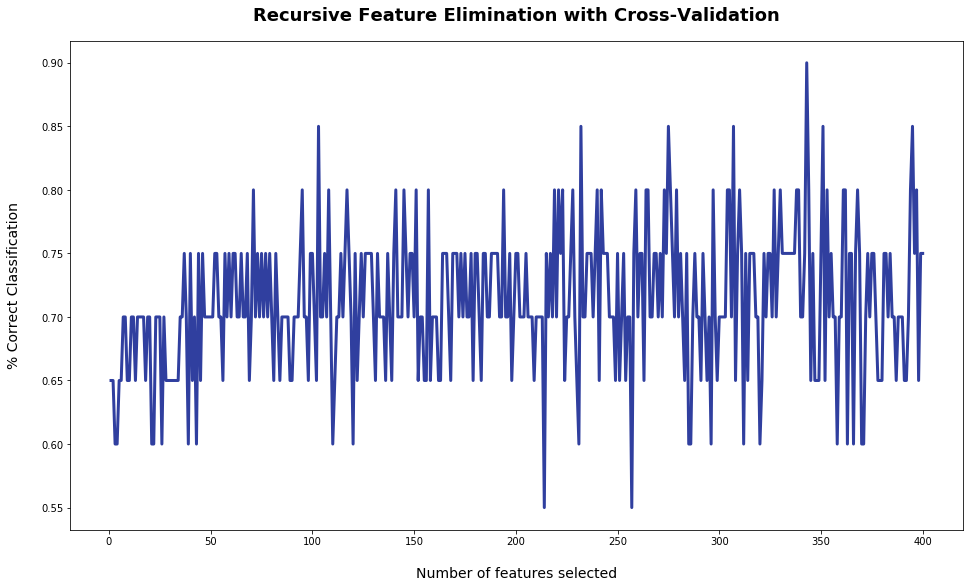

In [133]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

###### Dropping least important descriptors

In [134]:
print(np.where(rfecv.support_ == False)[0])

train.drop(train.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)
test.drop(test.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

[  0   1   2   3   4 176 177 178 179 180 181 182 183 184 185 186 187 188
 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206
 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224
 225 226 399]


In [197]:
train

,VE1_A,VR1_A,nAromAtom,nSpiro,nBridgehead,nH,nB,nN,nO,nS,...,SLogP,JGI2,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10,TopoShapeIndex
26,3.989248,179.986399,12,0,0,15,0,3,2,0,...,2.68240,0.065476,0.040362,0.023865,0.009515,0.014640,0.009574,0.007217,0.007414,0.857143
9,4.819938,183.316566,12,0,0,18,0,5,4,0,...,2.09900,0.086895,0.035038,0.028826,0.017143,0.015625,0.010097,0.009063,0.008072,1.000000
7,4.561329,210.869853,17,0,0,20,0,8,1,0,...,1.29070,0.064327,0.024377,0.028020,0.018295,0.011736,0.009113,0.008393,0.009068,1.000000
20,4.328259,561.790476,18,0,0,26,0,6,2,0,...,3.66064,0.052288,0.026194,0.027943,0.014496,0.013086,0.009859,0.009540,0.005906,1.000000
24,4.367584,549.602686,15,0,0,19,0,6,2,0,...,3.51298,0.074074,0.038463,0.026222,0.019152,0.014123,0.012124,0.009138,0.007070,0.875000
10,4.747259,419.620993,17,0,0,27,0,9,1,0,...,1.41290,0.053140,0.023889,0.025965,0.015395,0.010213,0.007749,0.007639,0.006485,0.900000
23,4.134028,180.284855,5,0,0,23,0,5,2,1,...,1.25930,0.080808,0.032796,0.031099,0.023850,0.017306,0.014143,0.010605,0.007522,1.000000
15,4.823638,530.661007,21,0,0,24,0,7,3,0,...,1.87990,0.072727,0.034931,0.021442,0.017890,0.010635,0.008011,0.007116,0.005979,1.000000
6,4.680105,186.452688,12,0,0,20,0,4,4,0,...,2.05060,0.085586,0.033764,0.028882,0.016961,0.013696,0.009962,0.008996,0.007448,1.000000
14,4.985878,258.000375,11,0,0,17,0,5,5,0,...,1.75900,0.086288,0.031133,0.029494,0.016569,0.014376,0.009877,0.009427,0.008426,0.857143


##### Descriptors' relevance

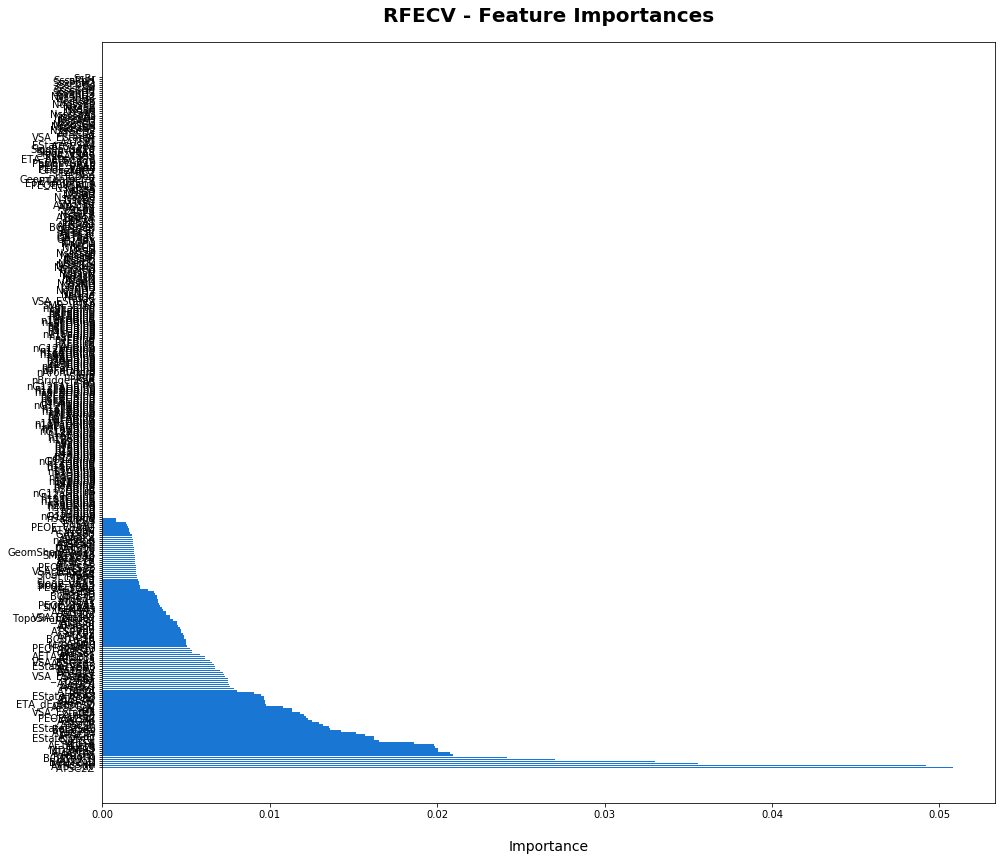

In [135]:
dset = pd.DataFrame()
dset['attr'] = train.columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()



In [137]:
dset

,attr,importance
49,ATSC2Z,0.050800
30,ATSC5dv,0.049211
182,MINssNH,0.035556
91,BCUTZ-1l,0.033018
111,AXp-1d,0.027052
...,...,...
176,SsI,0.000000
177,SsPbH3,0.000000
178,SssPbH2,0.000000
179,SsssPbH,0.000000


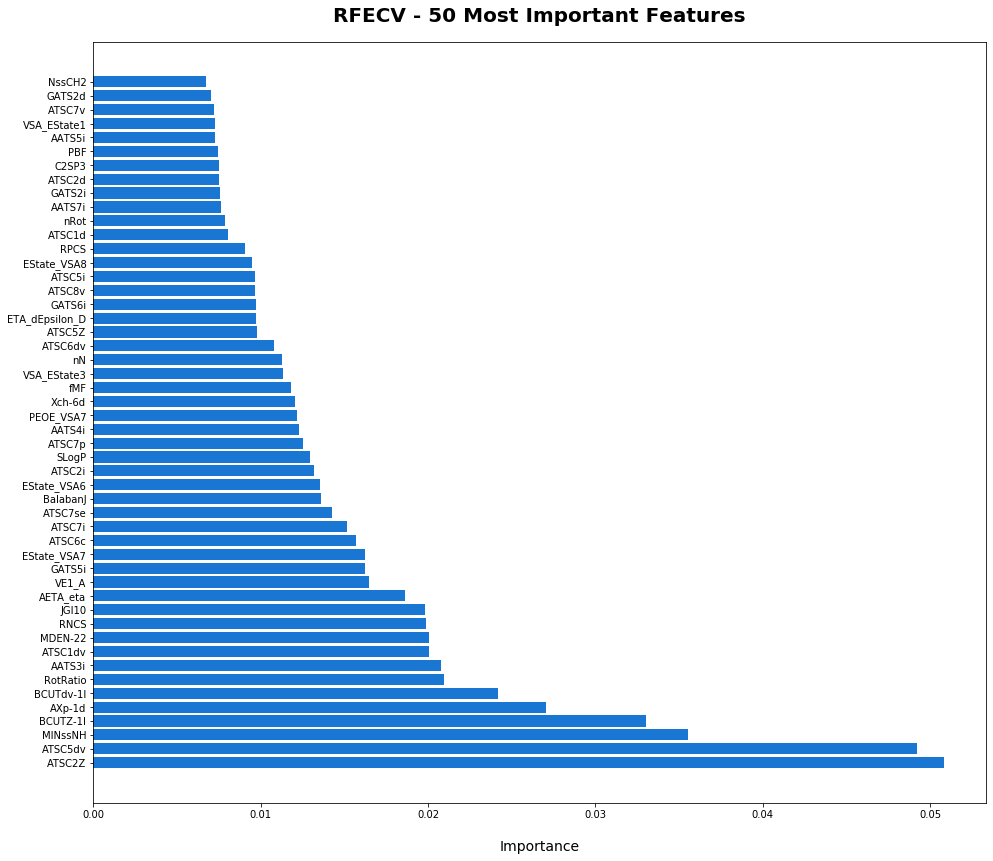

In [145]:
plt.figure(figsize=(16, 14))
plt.barh(y=dset.iloc[0:50,0], width=dset.iloc[0:50,1], color='#1976D2')
plt.title('RFECV - 50 Most Important Features', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

In [140]:
dset.iloc[[0:343],0]

SyntaxError: invalid syntax (<ipython-input-140-dbc889fb5a81>, line 1)

### Support Vector Machine (SVM) 

#### Grid search cross-validation and SVM classificator

In [165]:
C_range = np.arange(0.01, 100, step=5)
gamma_range = np.arange(0.1, 10, step=2)
kernels = ["linear","sigmoid","rbf","poly"]
parameters = dict(gamma=gamma_range, C=C_range, kernel=kernels)

svc = SVC()
clf = GridSearchCV(svc, param_grid = parameters)

In [166]:
clf.fit(train, ic50_train_enc)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.000e-02, 5.010e+00, 1.001e+01, 1.501e+01, 2.001e+01, 2.501e+01,
       3.001e+01, 3.501e+01, 4.001e+01, 4.501e+01, 5.001e+01, 5.501e+01,
       6.001e+01, 6.501e+01, 7.001e+01, 7.501e+01, 8.001e+01, 8.501e+01,
       9.001e+01, 9.501e+01]),
                         'gamma': array([0.1, 2.1, 4.1, 6.1, 8.1]),
                         'kernel': ['linear', 'sigmoid', 'rbf', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=N

In [167]:
ypred = clf.predict(test)

In [168]:
print("Accuracy: {}".format(metrics.accuracy_score(ic50_test_enc, ypred)))

Accuracy: 0.5714285714285714


In [169]:
clf.fit(train_sc, ic50_train_enc)
ypred = clf.predict(test_sc)
print("Accuracy: {} - standard".format(metrics.accuracy_score(ic50_test_enc, ypred)))
      
clf.fit(train_mmsc, ic50_train_enc)
ypred = clf.predict(test_mmsc)
print("Accuracy: {} - MinMax".format(metrics.accuracy_score(ic50_test_enc, ypred)))

clf.fit(train_masc, ic50_train_enc)
ypred = clf.predict(test_masc)
print("Accuracy: {} - MaxAbs".format(metrics.accuracy_score(ic50_test_enc, ypred)))

clf.fit(train_rsc, ic50_train_enc)
ypred = clf.predict(test_rsc)
print("Accuracy: {} - Robust".format(metrics.accuracy_score(ic50_test_enc, ypred)))

clf.fit(train_gsc, ic50_train_enc)
ypred = clf.predict(test_gsc)
print("Accuracy: {} - Gaussian".format(metrics.accuracy_score(ic50_test_enc, ypred)))

clf.fit(train_usc, ic50_train_enc)
ypred = clf.predict(test_usc)
print("Accuracy: {} - Uniform".format(metrics.accuracy_score(ic50_test_enc, ypred)))

clf.fit(train_nsc, ic50_train_enc)
ypred = clf.predict(test_nsc)
print("Accuracy: {} - Normalized".format(metrics.accuracy_score(ic50_test_enc, ypred)))


Accuracy: 0.7142857142857143 - standard
Accuracy: 0.7142857142857143 - MinMax
Accuracy: 0.7142857142857143 - MaxAbs
Accuracy: 0.7142857142857143 - Robust
Accuracy: 0.5714285714285714 - Gaussian
Accuracy: 0.7142857142857143 - Uniform
Accuracy: 0.7142857142857143 - Normalized


#### Grid search cross-validation and SVM regressor

In [198]:
from sklearn.svm import SVR
C_range = np.arange(0.01, 100, step=5)
gamma_range = np.arange(0.1, 10, step=2)
kernels = ["linear","sigmoid","rbf","poly"]
parameters = dict(gamma=gamma_range, C=C_range, kernel=kernels)

svr = SVR()
clf = GridSearchCV(svr, param_grid = parameters)

In [199]:
clf.fit(train, ic50_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.000e-02, 5.010e+00, 1.001e+01, 1.501e+01, 2.001e+01, 2.501e+01,
       3.001e+01, 3.501e+01, 4.001e+01, 4.501e+01, 5.001e+01, 5.501e+01,
       6.001e+01, 6.501e+01, 7.001e+01, 7.501e+01, 8.001e+01, 8.501e+01,
       9.001e+01, 9.501e+01]),
                         'gamma': array([0.1, 2.1, 4.1, 6.1, 8.1]),
                         'kernel': ['linear', 'sigmoid', 'rbf', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [200]:
ypred=clf.predict(test)

In [201]:
metrics.r2_score(ic50_test, ypred)

-0.20292853009538825

In [202]:
clf.fit(train_sc, ic50_train)
ypred = clf.predict(test_sc)
print("R²: {} - standard".format(metrics.r2_score(ic50_test, ypred)))
      
clf.fit(train_mmsc, ic50_train)
ypred = clf.predict(test_mmsc)
print("R²: {} - MinMax".format(metrics.r2_score(ic50_test, ypred)))

clf.fit(train_masc, ic50_train)
ypred = clf.predict(test_masc)
print("R²: {} - MaxAbs".format(metrics.r2_score(ic50_test, ypred)))

clf.fit(train_rsc, ic50_train)
ypred = clf.predict(test_rsc)
print("R²: {} - Robust".format(metrics.r2_score(ic50_test, ypred)))

clf.fit(train_gsc, ic50_train)
ypred = clf.predict(test_gsc)
print("R²: {} - Gaussian".format(metrics.r2_score(ic50_test, ypred)))

clf.fit(train_usc, ic50_train)
ypred = clf.predict(test_usc)
print("R²: {} - Uniform".format(metrics.r2_score(ic50_test, ypred)))

clf.fit(train_nsc, ic50_train)
ypred = clf.predict(test_nsc)
print("R²: {} - Normalized".format(metrics.r2_score(ic50_test, ypred)))

R²: -0.2149074803718638 - standard
R²: -0.5186944835542877 - MinMax
R²: -0.02816180684263081 - MaxAbs
R²: 0.09453798014895409 - Robust
R²: -0.04158018970281496 - Gaussian
R²: -0.1613270012926895 - Uniform
R²: -1.392243547239389 - Normalized


In [203]:
clf.fit(train_rsc, ic50_train)
ypred = clf.predict(test_rsc)
print("R²: {} - Robust".format(metrics.r2_score(ic50_test, ypred)))

R²: 0.09453798014895409 - Robust


In [204]:
X_grid = np.arange(min(train_rsc), max(train_rsc), 0.01) #this step required because data is feature scaled.
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(train_rsc, test_rsc, color = 'red')
plt.plot(X_grid, regressor.predict(X_grid), color = 'blue')
plt.title('Truth or Bluff (SVR)')
plt.xlabel('Position level')
plt.ylabel('Salary')
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

### Neural networks

#### Multi-Layer Perceptor Classifier (MLPC)

In [156]:
mlp = MLPClassifier(hidden_layer_sizes=(13,13,13),max_iter=500)

In [157]:
mlp.fit(train,ic50_train_enc)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(13, 13, 13), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [158]:
predictions = mlp.predict(test)

In [159]:
print(confusion_matrix(ic50_test_enc,predictions))
print(classification_report(ic50_test_enc,predictions))

[[3 1]
 [1 2]]
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.67      0.67      0.67         3

    accuracy                           0.71         7
   macro avg       0.71      0.71      0.71         7
weighted avg       0.71      0.71      0.71         7



In [160]:
mlp.fit(train_sc,ic50_train_enc)
predictions = mlp.predict(test_sc)
print("Standard")
print(classification_report(ic50_test_enc,predictions))

mlp.fit(train_mmsc,ic50_train_enc)
predictions = mlp.predict(test_mmsc)
print("----------------------------------------------")
print("MinMax")
print(classification_report(ic50_test_enc,predictions))

mlp.fit(train_masc,ic50_train_enc)
predictions = mlp.predict(test_masc)
print("----------------------------------------------")
print("MaxAbs")
print(classification_report(ic50_test_enc,predictions))

mlp.fit(train_rsc,ic50_train_enc)
predictions = mlp.predict(test_rsc)
print("----------------------------------------------")
print("Robust")
print(classification_report(ic50_test_enc,predictions))

mlp.fit(train_gsc,ic50_train_enc)
predictions = mlp.predict(test_gsc)
print("----------------------------------------------")
print("Gaussian")
print(classification_report(ic50_test_enc,predictions))

mlp.fit(train_usc,ic50_train_enc)
predictions = mlp.predict(test_usc)
print("----------------------------------------------")
print("Uniform")
print(classification_report(ic50_test_enc,predictions))

mlp.fit(train_nsc,ic50_train_enc)
predictions = mlp.predict(test_nsc)
print("----------------------------------------------")
print("Normalized")
print(classification_report(ic50_test_enc,predictions))

Standard
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.67      0.67      0.67         3

    accuracy                           0.71         7
   macro avg       0.71      0.71      0.71         7
weighted avg       0.71      0.71      0.71         7

----------------------------------------------
MinMax
              precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       0.50      0.67      0.57         3

    accuracy                           0.57         7
   macro avg       0.58      0.58      0.57         7
weighted avg       0.60      0.57      0.57         7

----------------------------------------------
MaxAbs
              precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       0.50      0.67      0.57         3

    accuracy                           0.57         7
   macro av

### Gradient Boosting Classifier

#### Learning rates

A learning rate that maximizes accuracy in both training and test sets.

In [161]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    gb_clf.fit(train_sc, ic50_train_enc)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(train_sc, ic50_train_enc)))
    print("Accuracy score (test): {0:.3f}".format(gb_clf.score(test_sc, ic50_test_enc)))
    print()

Learning rate:  0.05
Accuracy score (training): 1.000
Accuracy score (test): 0.571

Learning rate:  0.075
Accuracy score (training): 1.000
Accuracy score (test): 0.571

Learning rate:  0.1
Accuracy score (training): 1.000
Accuracy score (test): 0.571

Learning rate:  0.25
Accuracy score (training): 1.000
Accuracy score (test): 0.571

Learning rate:  0.5
Accuracy score (training): 1.000
Accuracy score (test): 0.571

Learning rate:  0.75
Accuracy score (training): 1.000
Accuracy score (test): 0.571

Learning rate:  1
Accuracy score (training): 1.000
Accuracy score (test): 0.286



In [162]:
gb_clf2 = GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=2, max_depth=2, random_state=0)
gb_clf2.fit(train_mmsc, ic50_train_enc)
predictions = gb_clf2.predict(test_mmsc)

print("Confusion Matrix:")
print(confusion_matrix(ic50_test_enc, predictions))

print("Classification Report")
print(classification_report(ic50_test_enc, predictions))

Confusion Matrix:
[[3 1]
 [0 3]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.75      1.00      0.86         3

    accuracy                           0.86         7
   macro avg       0.88      0.88      0.86         7
weighted avg       0.89      0.86      0.86         7



#### XGBoost Classifier

In [192]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

In [193]:
xgb_clf = XGBClassifier()

In [194]:
xgb_clf.fit(train_mmsc, ic50_train_enc)
xgb_clf

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [195]:
y_pred = xgb_clf.predict(test_mmsc)
predictions = [round(value) for value in y_pred]

In [196]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(ic50_test_enc, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 57.14%


In [ ]:
plt.scatter()

## All ligands

In [24]:
non_applying_descriptors = []
num_descriptors = len(all_ligands.columns)

for i in range(1, num_descriptors):
    if (str(all_ligands.dtypes[i]) != 'float64') and (str(all_ligands.dtypes[i]) != 'int64') and (str(all_ligands.dtypes[i]) != 'bool'):
        non_applying_descriptors.append(all_ligands.columns[i])
        

In [25]:
for descriptor in non_applying_descriptors:
    all_ligands.drop(columns=[descriptor], inplace=True)

In [27]:
all_ligands.head(64)

,Ligand,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,39_SD-027,16.401355,12.830851,0,0,27.538947,2.351515,4.658626,27.538947,1.311378,...,9.782844,72.950827,281.116427,7.808790,1085,28,108,124,5.916667,4.638889
1,24_SD-012,23.120752,17.496509,0,0,36.792136,2.500037,4.883480,36.792136,1.268694,...,10.341904,79.079406,418.142324,8.198869,2404,45,158,185,9.562500,6.097222
2,102_wo17590_77,20.413286,16.725919,0,0,34.468616,2.492661,4.888530,34.468616,1.325716,...,10.230955,80.593694,352.164774,7.655756,1672,41,140,168,7.500000,5.805556
3,1_BMS986165_PKD_TYK2_prw_nowater_nimbus01,25.569882,20.595148,0,2,41.680715,2.508615,4.935337,41.680715,1.302522,...,10.515777,88.755240,437.192386,7.948952,2867,53,178,216,9.944444,6.888889
4,60_wo14660_81,21.489002,17.014394,0,0,35.859929,2.400952,4.801904,35.859929,1.280712,...,10.136621,63.084823,378.144038,8.220523,2107,43,142,164,9.500000,6.277778
5,30_SD-018,21.339172,16.591226,0,0,35.567428,2.472600,4.869993,35.567428,1.317312,...,10.213579,76.236824,363.124386,8.856692,1900,42,144,170,7.750000,5.888889
6,71_wo14670_11,22.432916,17.827128,0,0,36.451821,2.420100,4.840201,36.451821,1.256959,...,10.253546,64.475941,415.111439,8.832158,2292,45,150,173,10.451389,6.333333
7,95_wo15310_41,26.139090,20.772484,0,0,44.291265,2.443295,4.863012,44.291265,1.302684,...,10.392834,89.570321,459.201888,7.783083,3628,53,176,208,10.722222,7.750000
8,8_BMS986165_PKD_TYK2_prw_nowaternimbus08,27.800593,21.595361,0,2,45.261588,2.507478,4.937619,45.261588,1.293188,...,10.576662,87.807318,478.198948,8.244809,3729,59,192,231,11.305556,7.555556
9,75_wo14670_1,20.978262,17.570194,0,0,33.944013,2.425675,4.843985,33.944013,1.257186,...,10.236346,80.454852,389.115775,8.459039,1819,42,142,166,9.951389,5.861111


In [28]:
all_ligands.sort_values(by=['Ligand'], inplace=True)
all_ligands.reset_index(drop=True, inplace=True)
all_ligands.head(64)

,Ligand,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,100_wo17590_27,21.120393,17.395811,0,0,35.044844,2.490618,4.890757,35.044844,1.297957,...,10.293196,76.495281,367.175673,7.649493,1874,42,144,172,7.750000,6.055556
1,101_wo17590_2,20.672506,16.728469,0,0,33.426006,2.491886,4.885283,33.426006,1.285616,...,10.242777,80.655048,354.160437,7.870232,1687,40,142,169,8.111111,5.611111
2,102_wo17590_77,20.413286,16.725919,0,0,34.468616,2.492661,4.888530,34.468616,1.325716,...,10.230955,80.593694,352.164774,7.655756,1672,41,140,168,7.500000,5.805556
3,103_wo17590_84,22.494166,17.412162,0,0,37.746202,2.495751,4.915320,37.746202,1.348079,...,10.391607,83.229942,380.159689,7.919994,2035,46,156,189,7.111111,6.083333
4,104_wo17590_85,23.241713,18.356884,0,0,38.878496,2.492046,4.885544,38.878496,1.340638,...,10.338414,84.830777,389.171256,8.107735,2337,44,160,192,7.361111,6.305556
5,105_wo17590_88,24.017769,19.082824,0,0,39.894904,2.492434,4.887571,39.894904,1.329830,...,10.396933,86.148121,406.186572,7.811280,2561,47,166,200,8.222222,6.500000
6,106_wo17590_89,26.485286,20.586688,0,0,42.676460,2.492619,4.886618,42.676460,1.293226,...,10.522046,89.726821,457.158641,8.963895,3425,52,184,220,10.284722,6.972222
7,107_wo17590_91,24.017769,19.082824,0,0,39.894904,2.492434,4.887571,39.894904,1.329830,...,10.396933,86.148121,405.166171,8.268697,2561,47,166,200,8.222222,6.500000
8,10_BMS986165_PKD_TYK2_prw_nowater_nimbus10,27.024536,20.894750,0,2,44.354454,2.506928,4.935683,44.354454,1.304543,...,10.525595,86.611577,461.203619,8.091292,3447,56,186,223,10.444444,7.361111
9,12_LAS203756,24.793826,18.444754,0,0,41.003700,2.499482,4.946810,41.003700,1.322700,...,10.454812,81.186093,423.150681,8.463014,2776,52,170,204,8.472222,6.694444


In [29]:
pic50_all_ligands = pd.read_excel('/home/alexis/Desktop/PeleAI_data/y_data_all_lignads.xlsx')
pic50_all_ligands.index

RangeIndex(start=0, stop=64, step=1)

In [30]:
pic50_all_ligands.head(64)

,Ligand,IC50
0,100_wo17590_27,-8.569
1,101_wo17590_2,-8.489
2,102_wo17590_77,-8.396
3,103_wo17590_84,-8.213
4,104_wo17590_85,-8.031
5,105_wo17590_88,-8.079
6,106_wo17590_89,-8.000
7,107_wo17590_91,-6.699
8,10_BMS986165_PKD_TYK2_prw_nowater_nimbus10,-7.301
9,12_LAS203756,-4.824


In [31]:
correlated_features = set()
correlation_matrix = all_ligands.drop('Ligand', axis=1).corr()

In [32]:
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i,j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
            
print(correlated_features)

set(['MATS3v', 'Xch-7dv', 'n12FaRing', 'MATS3s', 'MATS3p', 'SpAD_Dzare', 'MATS3d', 'Xch-3dv', 'AATSC7p', 'AATS6Z', 'MATS4Z', 'MATS3m', 'TMWC10', 'MATS3i', 'AATS6m', 'MATS2se', 'LogEE_Dzpe', 'SdsN', 'MATS4d', 'AATS6d', 'MATS4i', 'SpMAD_D', 'MATS3Z', 'Xch-5dv', 'MATS4m', 'MATS4s', 'MATS4p', 'MATS4v', 'AXp-6d', 'SpMAD_Dt', 'AETA_eta', 'AATS6v', 'AATS6p', 'AATS6s', 'ATS7Z', 'AATS4pe', 'Xp-5d', 'AETA_eta_R', 'n9FRing', 'TIC1', 'FPSA5', 'AATSC7i', 'FPSA3', 'SM1_Dzv', 'FPSA1', 'nBondsS', 'AATS7se', 'MATS6are', 'SsssN', 'nAtom', 'TIC4', 'SpAbs_Dzpe', 'GATS2se', 'AETA_eta_L', 'AATSC6pe', 'ATS5se', 'MATS3pe', 'RASA', 'ATS7s', 'ATS7p', 'ATS7v', 'n5AHRing', 'VE2_D', 'JGT10', 'WNSA2', 'ATS7i', 'WNSA4', 'VR3_Dzpe', 'ATS7m', 'Xpc-6d', 'BIC1', 'Spe', 'ATS7d', 'MATS3c', 'VE2_Dzse', 'VR3_Dzare', 'SsCH3', 'nHetero', 'Vabc', 'SpDiam_DzZ', 'ATS0pe', 'SaaNH', 'BCUTm-1l', 'BCUTm-1h', 'LogEE_A', 'LogEE_D', 'SpDiam_Dzv', 'SpDiam_Dzp', 'MATS1se', 'GATS5se', 'PNSA2', 'BIC4', 'AETA_beta_ns_d', 'SpDiam_Dzm', 'StsC

In [33]:
print("Correlated descriptors computed: {}".format(len(correlated_features)))
print("Number of descriptors before discard: {}".format(len(dummy_df.columns)))
dummy_df = dummy_df.drop(correlated_features, axis=1)
print("Number of descriptors after discard: {}".format(len(dummy_df.columns)))

Correlated descriptors computed: 1078
Number of descriptors before discard: 1827
Number of descriptors after discard: 749


In [34]:
all_ligands = all_ligands.merge(pic50_all_ligands, how='left')

In [63]:
train, test = train_test_split(all_ligands, test_size=0.24)

In [64]:
test

,Ligand,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2,IC50
61,97_wo15310_45,24.127159,19.656043,0,0,40.321270,2.440580,4.860107,40.321270,1.300686,...,86.274592,437.152161,8.095410,2712,49,164,195,9.972222,6.916667,-8.255
46,73_wo14670_13,23.208972,18.538010,0,0,37.361642,2.421466,4.842932,37.361642,1.245388,...,65.723308,429.127089,8.582542,2511,48,156,181,11.312500,6.527778,-7.699
12,15_LAS203932,23.529442,19.100026,0,0,38.633155,2.438811,4.855461,38.633155,1.287772,...,85.157707,408.165837,8.163317,2496,47,160,190,9.722222,6.583333,-11.456
53,8_BMS986165_PKD_TYK2_prw_nowaternimbus08,27.800593,21.595361,0,2,45.261588,2.507478,4.937619,45.261588,1.293188,...,87.807318,478.198948,8.244809,3729,59,192,231,11.305556,7.555556,-8.602
13,16_LAS203965,21.896449,17.252001,0,0,36.699679,2.550926,4.945786,36.699679,1.310703,...,79.570682,379.175673,7.738279,2170,45,150,180,8.611111,6.250000,-7.259
60,96_wo15310_44,24.127159,19.656043,2,0,40.321270,2.440580,4.860107,40.321270,1.300686,...,86.274592,422.181487,7.965688,2712,49,164,195,9.972222,6.916667,-8.818
26,28_SD-016,22.155669,17.063825,0,0,36.356972,2.472679,4.870604,36.356972,1.298463,...,77.455606,381.114964,9.295487,2128,44,150,177,8.611111,6.055556,-5.312
28,30_SD-018,21.339172,16.591226,0,0,35.567428,2.472600,4.869993,35.567428,1.317312,...,76.236824,363.124386,8.856692,1900,42,144,170,7.750000,5.888889,-6.000
32,34_SD-022,23.351103,17.432566,0,0,38.851559,2.476474,4.874258,38.851559,1.339709,...,84.320646,394.175339,7.728928,2415,45,160,191,7.361111,6.222222,-6.658
21,23_SD-011,21.679272,16.497091,0,0,35.105369,2.366948,4.718364,35.105369,1.253763,...,76.413702,381.191323,7.474340,2450,38,142,161,9.500000,6.138889,-7.854


In [65]:
train

,Ligand,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2,IC50
37,39_SD-027,16.401355,12.830851,0,0,27.538947,2.351515,4.658626,27.538947,1.311378,...,72.950827,281.116427,7.808790,1085,28,108,124,5.916667,4.638889,-4.824
27,29_SD-017,21.644929,17.872689,0,0,34.250817,2.485455,4.910524,34.250817,1.268549,...,82.151483,386.104876,8.580108,1793,43,150,179,9.062500,5.638889,-7.886
31,33_SD-021,25.622253,18.528464,0,0,41.807813,2.474584,4.879923,41.807813,1.306494,...,82.166191,430.211724,7.417444,3170,50,174,205,8.722222,6.861111,-6.469
19,21_SD-009,21.408122,17.992734,0,0,35.628419,2.415928,4.824665,35.628419,1.272444,...,81.665307,403.104732,8.763146,2062,45,144,170,10.111111,6.333333,-9.268
24,26_SD-014,25.012606,20.304076,0,0,40.924218,2.442549,4.848387,40.924218,1.278882,...,87.477037,461.090225,9.410005,2973,51,170,202,10.833333,7.027778,-7.066
18,20_SD-008,23.460493,18.668293,0,0,39.626117,2.411196,4.822392,39.626117,1.278262,...,66.616922,420.134617,8.752805,2826,50,156,182,10.861111,7.138889,-9.420
10,13_LAS203888,17.953468,15.053156,0,0,28.680180,2.481106,4.871045,28.680180,1.246964,...,71.498752,310.154209,7.564737,1182,36,122,144,8.250000,5.027778,-10.292
9,12_LAS203756,24.793826,18.444754,0,0,41.003700,2.499482,4.946810,41.003700,1.322700,...,81.186093,423.150681,8.463014,2776,52,170,204,8.472222,6.694444,-4.824
3,103_wo17590_84,22.494166,17.412162,0,0,37.746202,2.495751,4.915320,37.746202,1.348079,...,83.229942,380.159689,7.919994,2035,46,156,189,7.111111,6.083333,-8.213
40,60_wo14660_81,21.489002,17.014394,0,0,35.859929,2.400952,4.801904,35.859929,1.280712,...,63.084823,378.144038,8.220523,2107,43,142,164,9.500000,6.277778,-7.644


In [66]:
ic50_train_all_ligand = train['IC50']
ic50_test_all_ligand = test['IC50']

In [67]:
train.fillna(value=0.0, inplace=True)
test.fillna(value=0.0, inplace=True)

In [68]:
ic50_train_enc_all_ligand = [1 if ic50 > -7 else 0 for ic50 in ic50_train_all_ligand.values]
ic50_test_enc_all_ligand = [1 if ic50 > -7 else 0 for ic50 in ic50_test_all_ligand.values]

In [71]:
train.drop(['Ligand','IC50'], axis=1, inplace=True)
test.drop(['Ligand','IC50'], axis=1, inplace=True)

##### Standard

In [72]:
scaler = StandardScaler()

In [73]:
train_sc = scaler.fit_transform(train)
test_sc = scaler.fit_transform(test)

##### MinMax

In [74]:
scaler = MinMaxScaler()

In [75]:
train_mmsc = scaler.fit_transform(train)
test_mmsc = scaler.fit_transform(test)

##### MaxAbs

In [76]:
scaler = MaxAbsScaler()

In [77]:
train_masc = scaler.fit_transform(train)
test_masc = scaler.fit_transform(test)

##### Robust 

In [78]:
scaler = RobustScaler()

In [79]:
train_rsc = scaler.fit_transform(train)
test_rsc = scaler.fit_transform(test)

##### Power Transformer - Yeo-Johnson

In [80]:
scaler = PowerTransformer(method='yeo-johnson')

In [81]:
train_yjsc = scaler.fit_transform(train)
test_yjsc = scaler.fit_transform(test)

##### Quantile transformer - Gaussian

In [82]:
scaler = QuantileTransformer(output_distribution='normal')

In [83]:
train_gsc = scaler.fit_transform(train)
test_gsc = scaler.fit_transform(test)

##### Quantile transformer - Uniform

In [84]:
scaler = QuantileTransformer(output_distribution='uniform')

In [85]:
train_usc = scaler.fit_transform(train)
test_usc = scaler.fit_transform(test)

##### Normalizer

In [86]:
scaler = Normalizer()

In [87]:
train_nsc = scaler.fit_transform(train)
test_nsc = scaler.fit_transform(test)

## Feature selection

#### Shap values

In [ ]:
model = RandomForestClassifier(random_state=101)
model.fit(train, ic50_train_enc)

In [ ]:
shap_values = shap.TreeExplainer(model).shap_values(train)
shap.summary_plot(shap_values, train, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, train)

In [ ]:
shap.initjs()

In [ ]:
X_output = test.copy()
X_output.loc[:,'predict'] = np.round(model.predict(X_output),2)

# Randomly pick some observations
random_picks = np.arange(1,7,2) # Every 50 rows
S = X_output.iloc[random_picks]
S

In [ ]:
def shap_plot(j):
    explainerModel = shap.TreeExplainer(model)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
    return(p)

In [ ]:
shap_plot(0)

In [ ]:
shap_plot(1)

In [ ]:
shap_plot(2)

#### Pearson correlation

In [88]:
def cor_selector(X, y, num_feats):
    cor_list = []
    feature_name = X.columns.tolist()

    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)

    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    cor_support = [True if i in cor_feature else False for i in feature_name]
    
    return cor_support, cor_feature 

In [90]:
cor_support, cor_feature = cor_selector(train, ic50_train_enc_all_ligand, len(train.columns))
print(str(len(cor_feature)), 'selected features')

('1502', 'selected features')


#### LASSO

In [92]:
embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=len(train.columns))
embeded_lr_selector.fit(train_mmsc, ic50_train_enc_all_ligand)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = train.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

('566', 'selected features')


In [104]:
train_lasso = train.drop(train.columns[np.where(embeded_lr_support == False)[0]], axis=1)
test_lasso = test.drop(test.columns[np.where(embeded_lr_support == False)[0]], axis=1)

#### Chi-squared

In [93]:
chi_selector = SelectKBest(chi2, k=400)
chi_selector.fit(train_mmsc, ic50_train_enc_all_ligand)

SelectKBest(k=400, score_func=<function chi2 at 0x7f3f0ab58450>)

In [94]:
chi_support = chi_selector.get_support()
chi_feature = train.loc[:,chi_support].columns.tolist()

In [95]:
print(str(len(chi_feature)), 'selected features')

('400', 'selected features')


#### Light Gradient Boosting Classifier

In [97]:
lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

In [98]:
embeded_lgb_selector = SelectFromModel(lgbc, max_features=len(train.columns))
embeded_lgb_selector.fit(train_mmsc, ic50_train_enc_all_ligand)

SelectFromModel(estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.2,
        importance_type='split', learning_rate=0.05, max_depth=-1,
        min_child_samples=20, min_child_weight=40, min_split_gain=0.01,
        n_estimators=500, n_jobs=-1, num_leaves=32, objective=None,
        random_state=None, reg_alpha=3, reg_lambda=1, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
        max_features=1502, norm_order=1, prefit=False, threshold=None)

In [99]:
embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = train.loc[:,embeded_lgb_support].columns.tolist()

In [100]:
print(str(len(embeded_lgb_feature)), 'selected features')

('1502', 'selected features')


### Recursive feature elimination (RFE)

#### By Support Vector Classifier (SVC)

- Error report:

        * n_splits=2 cannot be greater than the number of members in each class.
        * The classifier does not expose "coef_" or "feature_importances_" attributes
        
Dependence on train/test split

In [103]:
svc = LinearSVC()
rfe = RFE(svc)
rfe.fit(train, ic50_train_enc_all_ligand)
print('Optimal number of features: {} - '.format(rfe.n_features_))
rfe.fit(train_sc, ic50_train_enc_all_ligand)
print('Optimal number of features: {} - Standard'.format(rfe.n_features_))
rfe.fit(train_mmsc, ic50_train_enc_all_ligand)
print('Optimal number of features: {} - MinMax'.format(rfe.n_features_))
rfe.fit(train_masc, ic50_train_enc_all_ligand)
print('Optimal number of features: {} - MaxAbs'.format(rfe.n_features_))
rfe.fit(train_rsc, ic50_train_enc_all_ligand)
print('Optimal number of features: {} - Robust'.format(rfe.n_features_))
rfe.fit(train_yjsc, ic50_train_enc_all_ligand)
print('Optimal number of features: {} - Yeo-Johnson'.format(rfe.n_features_))
rfe.fit(train_gsc, ic50_train_enc_all_ligand)
print('Optimal number of features: {} - Gaussian'.format(rfe.n_features_))
rfe.fit(train_usc, ic50_train_enc_all_ligand)
print('Optimal number of features: {} - uniform'.format(rfe.n_features_))
rfe.fit(train_nsc, ic50_train_enc_all_ligand)
print('Optimal number of features: {} - normalized'.format(rfe.n_features_))


Optimal number of features: 751 - 
Optimal number of features: 751 - Standard
Optimal number of features: 751 - MinMax
Optimal number of features: 751 - MaxAbs
Optimal number of features: 751 - Robust
Optimal number of features: 751 - Yeo-Johnson
Optimal number of features: 751 - Gaussian
Optimal number of features: 751 - uniform
Optimal number of features: 751 - normalized


In [105]:
#print(np.where(rfe.support_ == False)[0])

train.drop(train.columns[np.where(rfe.support_ == False)[0]], axis=1, inplace=True)
test.drop(test.columns[np.where(rfe.support_ == False)[0]], axis=1, inplace=True)

##### Standard

In [ ]:
scaler = StandardScaler()

In [ ]:
train_sc = scaler.fit_transform(train)
test_sc = scaler.fit_transform(test)

##### MinMax

In [ ]:
scaler = MinMaxScaler()

In [ ]:
train_mmsc = scaler.fit_transform(train)
test_mmsc = scaler.fit_transform(test)

##### MaxAbs

In [ ]:
scaler = MaxAbsScaler()

In [ ]:
train_masc = scaler.fit_transform(train)
test_masc = scaler.fit_transform(test)

##### Robust 

In [ ]:
scaler = RobustScaler()

In [ ]:
train_rsc = scaler.fit_transform(train)
test_rsc = scaler.fit_transform(test)

##### Power Transformer - Yeo-Johnson

In [ ]:
scaler = PowerTransformer(method='yeo-johnson')

In [ ]:
train_yjsc = scaler.fit_transform(train)
test_yjsc = scaler.fit_transform(test)

##### Quantile transformer - Gaussian

In [ ]:
scaler = QuantileTransformer(output_distribution='normal')

In [ ]:
train_gsc = scaler.fit_transform(train)
test_gsc = scaler.fit_transform(test)

##### Quantile transformer - Uniform

In [ ]:
scaler = QuantileTransformer(output_distribution='uniform')

In [ ]:
train_usc = scaler.fit_transform(train)
test_usc = scaler.fit_transform(test)

##### Normalizer

In [ ]:
scaler = Normalizer()

In [ ]:
train_nsc = scaler.fit_transform(train)
test_nsc = scaler.fit_transform(test)

#### By Ensemble, Random Forest (RF) and Extremely Randomized Trees (Extra Trees Classifier)

##### Ensemble

In [106]:
stump = DecisionTreeClassifier(max_depth=1)
ensemble = BaggingClassifier(base_estimator = stump, n_estimators = 1000, bootstrap = False)

In [107]:
stump.fit(train, np.ravel(ic50_train_enc_all_ligand))
ensemble.fit(train, np.ravel(ic50_train_enc_all_ligand))

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=False, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=1000, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [108]:
y_pred_stump = stump.predict(test)
y_pred_ensemble = ensemble.predict(test)

In [109]:
stump_accuracy = metrics.accuracy_score(ic50_test_enc_all_ligand, y_pred_stump)
ensemble_accuracy = metrics.accuracy_score(ic50_test_enc_all_ligand, y_pred_ensemble)

In [111]:
print("The accuracy of the stump is {}%".format(stump_accuracy*100))
print("The accuracy of the ensemble is {}%".format(ensemble_accuracy*100))

The accuracy of the stump is 75.0%
The accuracy of the ensemble is 75.0%


##### Random Forest

In [112]:
tree = DecisionTreeClassifier(max_depth = 1, splitter = "best", max_features = "sqrt")

random_forest = BaggingClassifier(base_estimator = tree, n_estimators = 1000,bootstrap = True)

In [113]:
tree.fit(train, np.ravel(ic50_train_enc_all_ligand))
random_forest.fit(train, np.ravel(ic50_train_enc_all_ligand))

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=1000, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [114]:
y_pred_tree = tree.predict(test)
y_pred_random_forest = random_forest.predict(test)

In [115]:
tree_accuracy = metrics.accuracy_score(ic50_test_enc_all_ligand, y_pred_tree)
random_forest_accuracy = metrics.accuracy_score(ic50_test_enc_all_ligand, y_pred_random_forest)

In [116]:
print("The accuracy of the tree is {}%".format(tree_accuracy*100))
print("The accuracy of the Random Forest is {}%".format(random_forest_accuracy*100))

The accuracy of the tree is 75.0%
The accuracy of the Random Forest is 68.75%


##### Extra Trees Classifier

In [117]:
rm_tree = DecisionTreeClassifier(max_depth = 1, splitter = "random", max_features = "sqrt")

extra_trees = BaggingClassifier(base_estimator = stump, n_estimators = 1000, bootstrap = False)

In [118]:
rm_tree.fit(train, np.ravel(ic50_train_enc_all_ligand))
extra_trees.fit(train, np.ravel(ic50_train_enc_all_ligand))

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=False, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=1000, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [119]:
y_pred_rm_tree = rm_tree.predict(test)
y_pred_extra_trees = extra_trees.predict(test)

In [120]:
rm_tree_accuracy = metrics.accuracy_score(ic50_test_enc_all_ligand, y_pred_rm_tree)
extra_trees_accuracy = metrics.accuracy_score(ic50_test_enc_all_ligand, y_pred_extra_trees)

In [121]:
print("The accuracy of the tree is {}%".format(rm_tree_accuracy*100))
print("The accuracy of the Extra Trees is {}%".format(extra_trees_accuracy*100))

The accuracy of the tree is 87.5%
The accuracy of the Extra Trees is 75.0%


##### Proceeding to RFE-CV with Random Forest Classifier

After several runs ...

In [122]:
rfc = RandomForestClassifier(random_state=101)

In [123]:
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(2), scoring='accuracy')

In [124]:
rfecv.fit(train, ic50_train_enc_all_ligand)

RFECV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
   estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=101, verbose=0, warm_start=False),
   min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
   verbose=0)

In [125]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 132


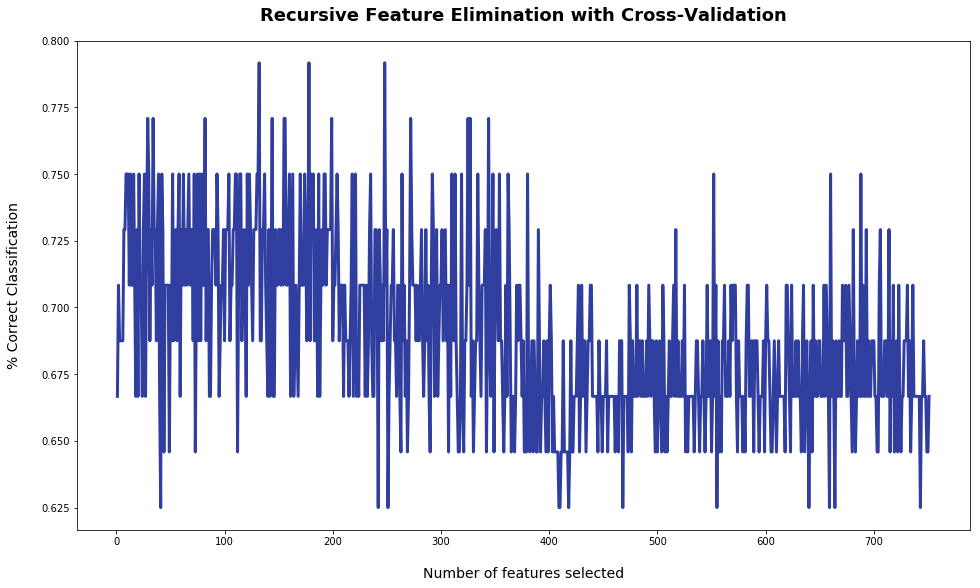

In [126]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

###### Dropping least important descriptors

In [127]:
print(np.where(rfecv.support_ == False)[0])

train.drop(train.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)
test.drop(test.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [173]:
train.columns

Index([u'ECIndex', u'ETA_alpha', u'ETA_beta', u'ETA_beta_s', u'ETA_beta_ns_d',
       u'ETA_eta_L', u'ETA_eta_R', u'ETA_eta_RL', u'ETA_eta_F', u'ETA_dBeta',
       ...
       u'MWC04', u'MWC05', u'MWC06', u'MWC07', u'MWC08', u'MWC09', u'MWC10',
       u'TMWC10', u'SRW02', u'SRW04'],
      dtype='object', length=132)

##### Descriptors' relevance

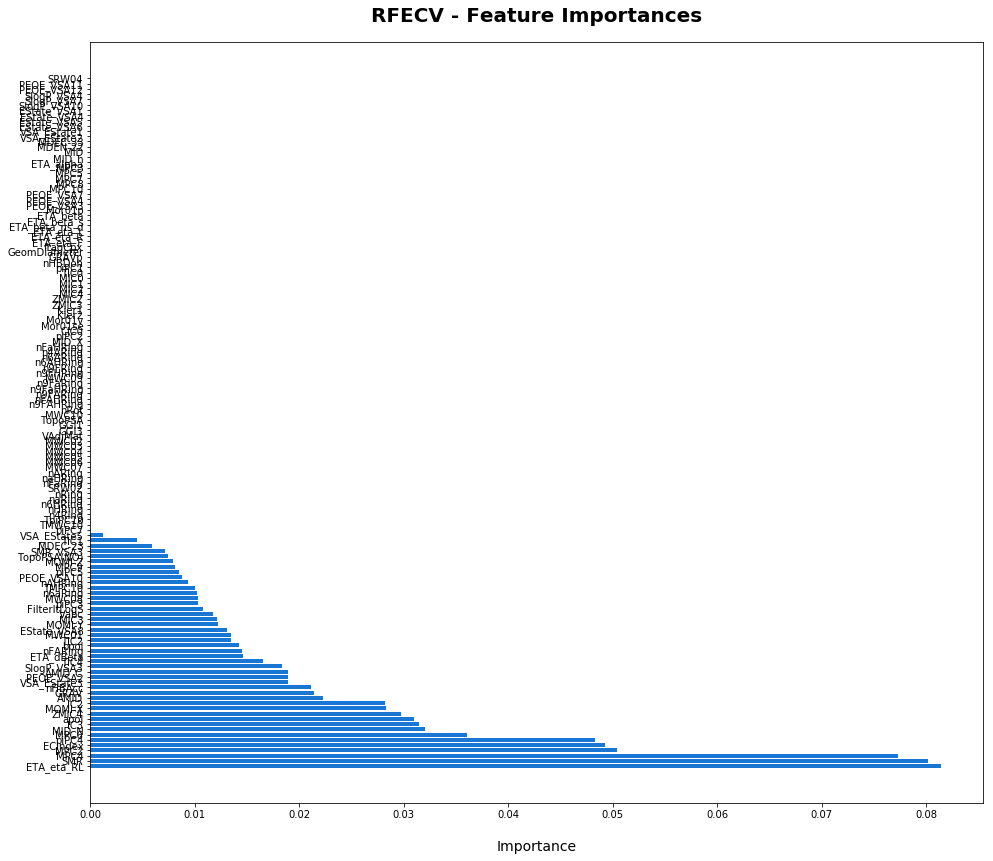

In [128]:
dset = pd.DataFrame()
dset['attr'] = train.columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()



In [137]:
dset

,attr,importance
49,ATSC2Z,0.050800
30,ATSC5dv,0.049211
182,MINssNH,0.035556
91,BCUTZ-1l,0.033018
111,AXp-1d,0.027052
...,...,...
176,SsI,0.000000
177,SsPbH3,0.000000
178,SssPbH2,0.000000
179,SsssPbH,0.000000


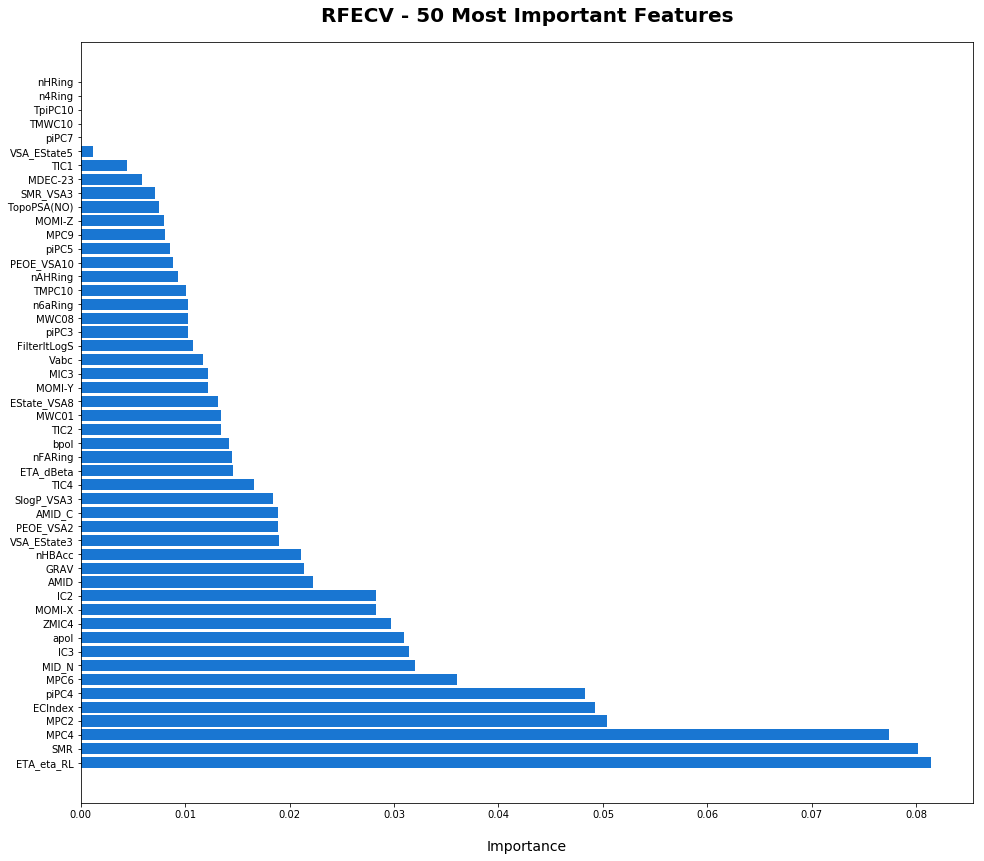

In [129]:
plt.figure(figsize=(16, 14))
plt.barh(y=dset.iloc[0:50,0], width=dset.iloc[0:50,1], color='#1976D2')
plt.title('RFECV - 50 Most Important Features', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

In [140]:
dset.iloc[[0:343],0]

SyntaxError: invalid syntax (<ipython-input-140-dbc889fb5a81>, line 1)

### Support Vector Machine (SVM) 

#### Grid search cross-validation and SVM classificator

In [130]:
C_range = np.arange(0.01, 100, step=5)
gamma_range = np.arange(0.1, 10, step=2)
kernels = ["linear","sigmoid","rbf","poly"]
parameters = dict(gamma=gamma_range, C=C_range, kernel=kernels)

svc = SVC()
clf = GridSearchCV(svc, param_grid = parameters)

In [131]:
clf.fit(train, ic50_train_enc_all_ligand)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kernel': ['linear', 'sigmoid', 'rbf', 'poly'], 'C': array([1.000e-02, 5.010e+00, 1.001e+01, 1.501e+01, 2.001e+01, 2.501e+01,
       3.001e+01, 3.501e+01, 4.001e+01, 4.501e+01, 5.001e+01, 5.501e+01,
       6.001e+01, 6.501e+01, 7.001e+01, 7.501e+01, 8.001e+01, 8.501e+01,
       9.001e+01, 9.501e+01]), 'gamma': array([0.1, 2.1, 4.1, 6.1, 8.1])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [133]:
ypred = clf.predict(test)

In [134]:
print("Accuracy: {}".format(metrics.accuracy_score(ic50_test_enc_all_ligand, ypred)))

Accuracy: 0.6875


In [135]:
clf.fit(train_sc, ic50_train_enc_all_ligand)
ypred = clf.predict(test_sc)
print("Accuracy: {} - standard".format(metrics.accuracy_score(ic50_test_enc_all_ligand, ypred)))
      
clf.fit(train_mmsc, ic50_train_enc_all_ligand)
ypred = clf.predict(test_mmsc)
print("Accuracy: {} - MinMax".format(metrics.accuracy_score(ic50_test_enc_all_ligand, ypred)))

clf.fit(train_masc, ic50_train_enc_all_ligand)
ypred = clf.predict(test_masc)
print("Accuracy: {} - MaxAbs".format(metrics.accuracy_score(ic50_test_enc_all_ligand, ypred)))

clf.fit(train_rsc, ic50_train_enc_all_ligand)
ypred = clf.predict(test_rsc)
print("Accuracy: {} - Robust".format(metrics.accuracy_score(ic50_test_enc_all_ligand, ypred)))

clf.fit(train_gsc, ic50_train_enc_all_ligand)
ypred = clf.predict(test_gsc)
print("Accuracy: {} - Gaussian".format(metrics.accuracy_score(ic50_test_enc_all_ligand, ypred)))

clf.fit(train_usc, ic50_train_enc_all_ligand)
ypred = clf.predict(test_usc)
print("Accuracy: {} - Uniform".format(metrics.accuracy_score(ic50_test_enc_all_ligand, ypred)))

clf.fit(train_nsc, ic50_train_enc_all_ligand)
ypred = clf.predict(test_nsc)
print("Accuracy: {} - Normalized".format(metrics.accuracy_score(ic50_test_enc_all_ligand, ypred)))


Accuracy: 0.5625 - standard
Accuracy: 0.8125 - MinMax
Accuracy: 0.6875 - MaxAbs
Accuracy: 0.6875 - Robust
Accuracy: 0.6875 - Gaussian
Accuracy: 0.8125 - Uniform
Accuracy: 0.75 - Normalized


#### Grid search cross-validation and SVM regressor

In [136]:
from sklearn.svm import SVR
C_range = np.arange(0.01, 100, step=5)
gamma_range = np.arange(0.1, 10, step=2)
kernels = ["linear","sigmoid","rbf","poly"]
parameters = dict(gamma=gamma_range, C=C_range, kernel=kernels)

svr = SVR()
clf = GridSearchCV(svr, param_grid = parameters)

In [137]:
clf.fit(train, ic50_train_all_ligand)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kernel': ['linear', 'sigmoid', 'rbf', 'poly'], 'C': array([1.000e-02, 5.010e+00, 1.001e+01, 1.501e+01, 2.001e+01, 2.501e+01,
       3.001e+01, 3.501e+01, 4.001e+01, 4.501e+01, 5.001e+01, 5.501e+01,
       6.001e+01, 6.501e+01, 7.001e+01, 7.501e+01, 8.001e+01, 8.501e+01,
       9.001e+01, 9.501e+01]), 'gamma': array([0.1, 2.1, 4.1, 6.1, 8.1])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [200]:
ypred=clf.predict(test)

In [138]:
metrics.r2_score(ic50_test_all_ligand, ypred)

-28.697947509748403

In [140]:
clf.fit(train_sc, ic50_train_all_ligand)
ypred = clf.predict(test_sc)
print("R²: {} - standard".format(metrics.r2_score(ic50_test_all_ligand, ypred)))
      
clf.fit(train_mmsc, ic50_train_all_ligand)
ypred = clf.predict(test_mmsc)
print("R²: {} - MinMax".format(metrics.r2_score(ic50_test_all_ligand, ypred)))

clf.fit(train_masc, ic50_train_all_ligand)
ypred = clf.predict(test_masc)
print("R²: {} - MaxAbs".format(metrics.r2_score(ic50_test_all_ligand, ypred)))

clf.fit(train_rsc, ic50_train_all_ligand)
ypred = clf.predict(test_rsc)
print("R²: {} - Robust".format(metrics.r2_score(ic50_test_all_ligand, ypred)))

clf.fit(train_gsc, ic50_train_all_ligand)
ypred = clf.predict(test_gsc)
print("R²: {} - Gaussian".format(metrics.r2_score(ic50_test_all_ligand, ypred)))

clf.fit(train_usc, ic50_train_all_ligand)
ypred = clf.predict(test_usc)
print("R²: {} - Uniform".format(metrics.r2_score(ic50_test_all_ligand, ypred)))

clf.fit(train_nsc, ic50_train_all_ligand)
ypred = clf.predict(test_nsc)
print("R²: {} - Normalized".format(metrics.r2_score(ic50_test_all_ligand, ypred)))

R²: 0.0766941594244 - standard
R²: 0.199351745288 - MinMax
R²: 0.189223075458 - MaxAbs
R²: 0.0765316849929 - Robust
R²: 0.162089264078 - Gaussian
R²: 0.282314134561 - Uniform
R²: 0.082966341711 - Normalized


AttributeError: 'str' object has no attribute 'foramt'

In [203]:
clf.fit(train_rsc, ic50_train)
ypred = clf.predict(test_rsc)
print("R²: {} - Robust".format(metrics.r2_score(ic50_test, ypred)))

R²: 0.09453798014895409 - Robust


In [204]:
X_grid = np.arange(min(train_rsc), max(train_rsc), 0.01) #this step required because data is feature scaled.
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(train_rsc, test_rsc, color = 'red')
plt.plot(X_grid, regressor.predict(X_grid), color = 'blue')
plt.title('Truth or Bluff (SVR)')
plt.xlabel('Position level')
plt.ylabel('Salary')
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

### Neural networks

#### Multi-Layer Perceptor Classifier (MLPC)

In [157]:
mlp = MLPClassifier(hidden_layer_sizes=(13,13,13),max_iter=500)

In [158]:
mlp.fit(train,ic50_train_enc_all_ligand)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(13, 13, 13), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [159]:
predictions = mlp.predict(test)

In [160]:
print(confusion_matrix(ic50_test_enc_all_ligand,predictions))
print(classification_report(ic50_test_enc_all_ligand,predictions))

[[11  0]
 [ 5  0]]
              precision    recall  f1-score   support

           0       0.69      1.00      0.81        11
           1       0.00      0.00      0.00         5

   micro avg       0.69      0.69      0.69        16
   macro avg       0.34      0.50      0.41        16
weighted avg       0.47      0.69      0.56        16



In [161]:
mlp.fit(train_sc,ic50_train_enc)
predictions = mlp.predict(test_sc)
print("Standard")
print(classification_report(ic50_test_enc,predictions))

mlp.fit(train_mmsc,ic50_train_enc)
predictions = mlp.predict(test_mmsc)
print("----------------------------------------------")
print("MinMax")
print(classification_report(ic50_test_enc,predictions))

mlp.fit(train_masc,ic50_train_enc)
predictions = mlp.predict(test_masc)
print("----------------------------------------------")
print("MaxAbs")
print(classification_report(ic50_test_enc,predictions))

mlp.fit(train_rsc,ic50_train_enc)
predictions = mlp.predict(test_rsc)
print("----------------------------------------------")
print("Robust")
print(classification_report(ic50_test_enc,predictions))

mlp.fit(train_gsc,ic50_train_enc)
predictions = mlp.predict(test_gsc)
print("----------------------------------------------")
print("Gaussian")
print(classification_report(ic50_test_enc,predictions))

mlp.fit(train_usc,ic50_train_enc)
predictions = mlp.predict(test_usc)
print("----------------------------------------------")
print("Uniform")
print(classification_report(ic50_test_enc,predictions))

mlp.fit(train_nsc,ic50_train_enc)
predictions = mlp.predict(test_nsc)
print("----------------------------------------------")
print("Normalized")
print(classification_report(ic50_test_enc,predictions))

NameError: name 'ic50_train_enc' is not defined

### Gradient Boosting Classifier

#### Learning rates

A learning rate that maximizes accuracy in both training and test sets.

In [162]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    gb_clf.fit(train_sc, ic50_train_enc_all_ligand)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(train_sc, ic50_train_enc_all_ligand)))
    print("Accuracy score (test): {0:.3f}".format(gb_clf.score(test_sc, ic50_test_enc_all_ligand)))
    print()

('Learning rate: ', 0.05)
Accuracy score (training): 0.854
Accuracy score (test): 0.688
()
('Learning rate: ', 0.075)
Accuracy score (training): 0.896
Accuracy score (test): 0.625
()
('Learning rate: ', 0.1)
Accuracy score (training): 0.938
Accuracy score (test): 0.625
()
('Learning rate: ', 0.25)
Accuracy score (training): 1.000
Accuracy score (test): 0.625
()
('Learning rate: ', 0.5)
Accuracy score (training): 1.000
Accuracy score (test): 0.688
()
('Learning rate: ', 0.75)
Accuracy score (training): 1.000
Accuracy score (test): 0.625
()
('Learning rate: ', 1)
Accuracy score (training): 1.000
Accuracy score (test): 0.562
()


In [164]:
gb_clf2 = GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=2, max_depth=2, random_state=0)
gb_clf2.fit(train_mmsc, ic50_train_enc_all_ligand)
predictions = gb_clf2.predict(test_mmsc)

print("Confusion Matrix:")
print(confusion_matrix(ic50_test_enc_all_ligand, predictions))

print("Classification Report")
print(classification_report(ic50_test_enc_all_ligand, predictions))

Confusion Matrix:
[[4 7]
 [1 4]]
Classification Report
              precision    recall  f1-score   support

           0       0.80      0.36      0.50        11
           1       0.36      0.80      0.50         5

   micro avg       0.50      0.50      0.50        16
   macro avg       0.58      0.58      0.50        16
weighted avg       0.66      0.50      0.50        16



#### XGBoost Classifier

In [166]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

In [167]:
xgb_clf = XGBClassifier()

In [168]:
xgb_clf.fit(train_mmsc, ic50_train_enc_all_ligand)
xgb_clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [169]:
y_pred = xgb_clf.predict(test_mmsc)
predictions = [round(value) for value in y_pred]

In [171]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(ic50_test_enc_all_ligand, predictions)
print("Accuracy: {}%".format(accuracy * 100.0))

Accuracy: 50.0%
